**Description:** This notebook contains the deep learning part of the project, which includes two models:

- **Artifical Neural Network**

- **Artifical Neural Network with Embedding of categorical features (deep and wide network)**

In this notebook the model setup for the Artificial Neural Network (ANN)is presented, one run on the unbalanced dataset, one ANN on an undersampled dataset and one ANN run on an oversampled dataset. Further a small follow up EDA was done after the model prediction to examine details of the missed and wrong predicted (FN and FP) churning customers. 

In the second part an Artificial Neural Network is developed with an implemented embedding of all categorical features. This type of neural network is called deep and wide neural network. The ANN with embedding is then used to do the prediction with the selected numerical features of the machine learning part (37 features without the categorical features, since these are included in the embedding). 

**Project Name:** Churn Prediction - Die Zeit

**Team:** Carlotta Ulm, Silas Mederer, Jonas Bechthold

**Date:** 2020-10-26 to 2020-11-27

# ANN with selected numerical and categorical features

## Imports, Load Data, Preprocessing

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Encoding the Independent Variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

#Importing Keras & classes
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.callbacks import TensorBoard
from keras.metrics import Recall, Precision

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/Users/carlottaulm/nf-sep-20/nf-Capstone/data/df_clean_engineered_all.csv')

In [3]:
y = df['churn'] 
df = pd.get_dummies(df, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
                                   'zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 
                                   'anrede','titel'], drop_first = True)

We choose the same 51 important features that we have identified. You can find the method in the [ML Notebook](https://github.com/jb-ds2020/nf-ds3-capstone-churn-prevention/blob/main/ML-Capstone_Zeit.ipynb).

In [4]:
features = ['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_halbjährlich',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_ZEIT Digital',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'anrede_Frau',
 'aboform_name_Geschenkabo',
 'unsubscribed_anzahl_1m',
 'studentenabo',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'opened_anzahl_bestandskunden_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_opened_1m',
 'kanal_andere',
 'kanal_B2B',
 'clicked_anzahl_6m',
 'che_reg',
 'MONTH_DELTA_nl_min',
 'zon_zp_red',
 'zahlung_rhythmus_name_vierteljährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'shop_kauf',
 'plz_2_10',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'openrate_3m',
 'openrate_1m',
 'nl_unsubscribed_6m',
 'nl_fdz_organisch',
 'metropole',
 'cnt_abo_magazin',
 'cnt_abo_diezeit_digital',
 'cnt_abo',
 'clicked_anzahl_bestandskunden_3m',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [5]:
X = df[features]

In [6]:
len(features)

51

### Splitting the Dataframe 

In [7]:
# devide features
categoric_features = list(X.columns[X.dtypes==object])

numeric_features = list(X.columns[X.dtypes != object])

# split train and test set
df, df_test = train_test_split(df, random_state=1, stratify=y)

In [8]:
X_train = df[features]
y_train = df['churn']
X_test = df_test[features]
y_test = df_test['churn']

In [9]:
df = df.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

### Preprocessor

In [10]:
#create preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer_num', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
y_train = y_train.to_numpy()

In [13]:
y_test = y_test.to_numpy()

### Model Settings

In [14]:
BATCH_SIZE = 1024
STEPS_PER_EPOCH = 138495//BATCH_SIZE
STEPS_PER_EPOCH

135

### Learning Rate Decay

In [15]:
init_learning_rate = 0.01
epochs_per_decay = 100 
decay_rate = 1
LR_decay = False

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  init_learning_rate,
  decay_steps=STEPS_PER_EPOCH*epochs_per_decay,
  decay_rate=decay_rate,
  staircase=False)

def get_optimizer():
    if LR_decay:
        return tf.keras.optimizers.Adam(lr_schedule)
    else: 
        return tf.keras.optimizers.Adam()

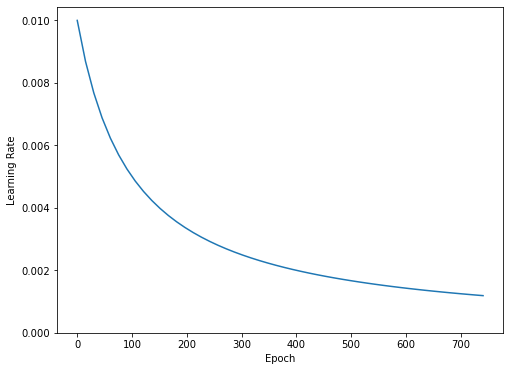

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

### Define Metrics

In [17]:
Recall = tf.keras.metrics.Recall(name='recall')
Precision = tf.keras.metrics.Precision(name='precision')
Loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy')

### Early Stopping

In [19]:
cb_recall = tf.keras.callbacks.EarlyStopping(monitor='recall', patience=100)
cb_epoch_dots = tfdocs.modeling.EpochDots(report_every=10)

### Gradient Check every n steps

In [20]:
class ExtendedTensorBoard(keras.callbacks.TensorBoard):
    def _log_gradients(self, epoch):
        writer = self._get_writer(self._train_run_name)

        with writer.as_default(), tf.GradientTape() as g:
            # here we use test data to calculate the gradients
            features, y_true = list(val_dataset.batch(100).take(1))[0]

            y_pred = self.model(features)  # forward-propagation
            loss = self.model.compiled_loss(y_true=y_true, y_pred=y_pred)  # calculate loss
            gradients = g.gradient(loss, self.model.trainable_weights)  # back-propagation

            # In eager mode, grads does not have name, so we get names from model.trainable_weights
            for weights, grads in zip(self.model.trainable_weights, gradients):
                tf.summary.histogram(
                    weights.name.replace(':', '_') + '_grads', data=grads, step=epoch)

        writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        # This function overwrites the on_epoch_end in tf.keras.callbacks.TensorBoard
        # but we do need to run the original on_epoch_end, so here we use the super function.
        super(ExtendedTensorBoard, self).on_epoch_end(epoch, logs=logs)

        if self.histogram_freq and epoch % self.histogram_freq == 0:
            self._log_gradients(epoch)

            
gradient_cb = ExtendedTensorBoard()

## NN - No Balanace
The first Neural Network is performed on the raw dataset and the 51 selected features. <br>
We tried different ANN compositions with different layer and neuron number, different dropout rates, different regularizations and different activation functions. At the end the following Model set up showed the best results:

In [21]:
model = tf.keras.Sequential([
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(51,)),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer =get_optimizer(), 
                loss=Loss,
                metrics=[Loss, Recall, Precision,'accuracy'])
   
history_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size=1024,
                                                          callbacks=[cb_epoch_dots],verbose=0) 


Epoch: 0, accuracy:0.6925,  binary_crossentropy:0.5927,  loss:0.6168,  precision:0.4337,  recall:0.0467,  val_accuracy:0.7173,  val_binary_crossentropy:0.5570,  val_loss:0.5785,  val_precision:0.6406,  val_recall:0.1538,  
..........
Epoch: 10, accuracy:0.7462,  binary_crossentropy:0.5265,  loss:0.5352,  precision:0.6372,  recall:0.3779,  val_accuracy:0.7514,  val_binary_crossentropy:0.5203,  val_loss:0.5287,  val_precision:0.6575,  val_recall:0.3758,  
..........
Epoch: 20, accuracy:0.7522,  binary_crossentropy:0.5185,  loss:0.5259,  precision:0.6508,  recall:0.3940,  val_accuracy:0.7546,  val_binary_crossentropy:0.5130,  val_loss:0.5205,  val_precision:0.6559,  val_recall:0.4004,  
..........
Epoch: 30, accuracy:0.7551,  binary_crossentropy:0.5135,  loss:0.5211,  precision:0.6580,  recall:0.3999,  val_accuracy:0.7574,  val_binary_crossentropy:0.5100,  val_loss:0.5175,  val_precision:0.6691,  val_recall:0.3954,  
..........
Epoch: 40, accuracy:0.7582,  binary_crossentropy:0.5113,  lo

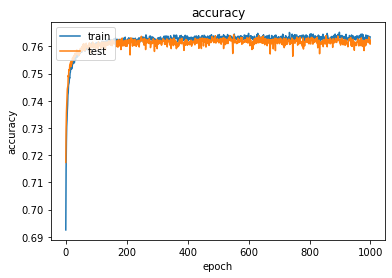

In [23]:
plt.plot(history_model.history['accuracy']) 
plt.plot(history_model.history['val_accuracy']) 
plt.title('accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

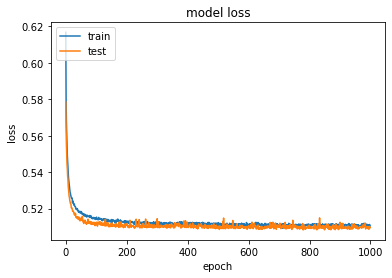

In [24]:
plt.plot(history_model.history['loss']) 
plt.plot(history_model.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [25]:
# Predicting the Test set results
y_pred_proba = model.predict(X_test)
#Converting probabilities into a binary result
y_pred = (y_pred_proba > 0.5)

In [26]:
# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[29113  3057]
 [ 7984  6011]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84     32170
           1       0.66      0.43      0.52     13995

    accuracy                           0.76     46165
   macro avg       0.72      0.67      0.68     46165
weighted avg       0.75      0.76      0.74     46165



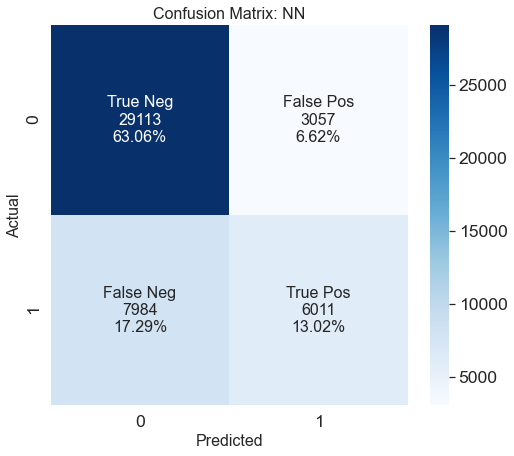

In [27]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: NN', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
#plt.savefig('plots/confusion_matrix_NN_under.png',dpi=300)

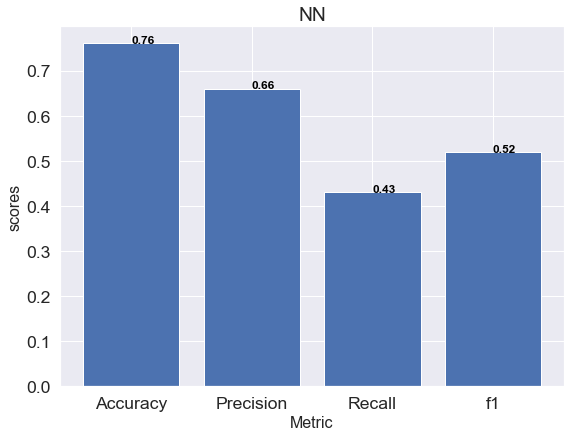

In [28]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
metrics = ['Accuracy', 'Precision', 'Recall', 'f1']
scores = [0.76 ,0.66,0.43,0.52]
ax.bar(metrics,scores)
ax.set_ylabel('scores',fontsize= 16)
ax.set_xlabel('Metric',fontsize= 16)
ax.set_title('NN')
for i, v in enumerate(scores):
    ax.text( i ,v, str(v), color='black', fontweight='bold', fontsize=12)
    #plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

__Conclusion:__ The accuracy and precision of this model are quite high, but we want to focus on the Recall and identify as many churning customers as possible. Due to an imbalanced data set the prediction for churn(1) is much worse than that for no churn(0).

## NN - undersampling
Due to the imbalanced data set we just described we resample the dataset by undersampling the majority class and run the same NN on the undersampled data. 

In [29]:
from imblearn.under_sampling import RandomUnderSampler
print('Undersampling')
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train, y_train)

Undersampling


In [30]:
model_under = tf.keras.Sequential([
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(51,)),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])

In [31]:
model_under.compile( optimizer =get_optimizer(), 
                loss=Loss,
                metrics=[Loss, Recall, Precision,'accuracy'])
   
history_model_under = model_under.fit(X_under, y_under, validation_data=(X_test, y_test), epochs=1000, batch_size=1024,
                                                          callbacks=[cb_epoch_dots],verbose=0) 


Epoch: 0, accuracy:0.5874,  binary_crossentropy:0.6706,  loss:0.6944,  precision:0.5853,  recall:0.5997,  val_accuracy:0.6505,  val_binary_crossentropy:0.6265,  val_loss:0.6498,  val_precision:0.4482,  val_recall:0.6624,  
..........
Epoch: 10, accuracy:0.6771,  binary_crossentropy:0.6065,  loss:0.6183,  precision:0.6867,  recall:0.6513,  val_accuracy:0.6827,  val_binary_crossentropy:0.5990,  val_loss:0.6113,  val_precision:0.4833,  val_recall:0.6739,  
..........
Epoch: 20, accuracy:0.6862,  binary_crossentropy:0.5919,  loss:0.6065,  precision:0.6902,  recall:0.6759,  val_accuracy:0.7015,  val_binary_crossentropy:0.5812,  val_loss:0.5912,  val_precision:0.5059,  val_recall:0.6489,  
..........
Epoch: 30, accuracy:0.6893,  binary_crossentropy:0.5885,  loss:0.6005,  precision:0.6950,  recall:0.6745,  val_accuracy:0.6941,  val_binary_crossentropy:0.5904,  val_loss:0.5996,  val_precision:0.4967,  val_recall:0.6868,  
..........
Epoch: 40, accuracy:0.6939,  binary_crossentropy:0.5868,  lo

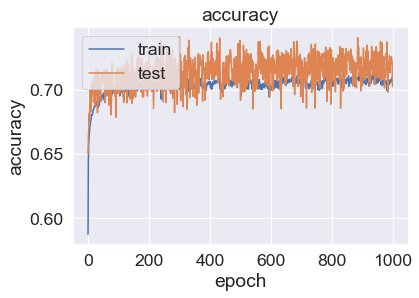

In [32]:
plt.plot(history_model_under.history['accuracy']) 
plt.plot(history_model_under.history['val_accuracy']) 
plt.title('accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

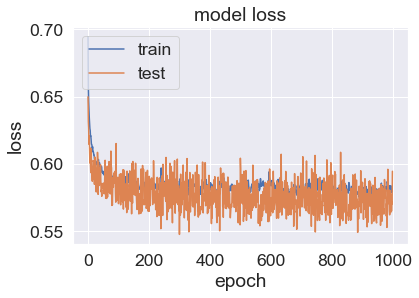

In [33]:
plt.plot(history_model_under.history['loss']) 
plt.plot(history_model_under.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [34]:
# Predicting the Test set results
y_pred_proba_under = model_under.predict(X_test)
#Converting probabilities into a binary result
y_pred_under = (y_pred_proba_under > 0.5)

In [35]:
# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test,y_pred_under))

[[22612  9558]
 [ 4182  9813]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.77     32170
           1       0.51      0.70      0.59     13995

    accuracy                           0.70     46165
   macro avg       0.68      0.70      0.68     46165
weighted avg       0.74      0.70      0.71     46165



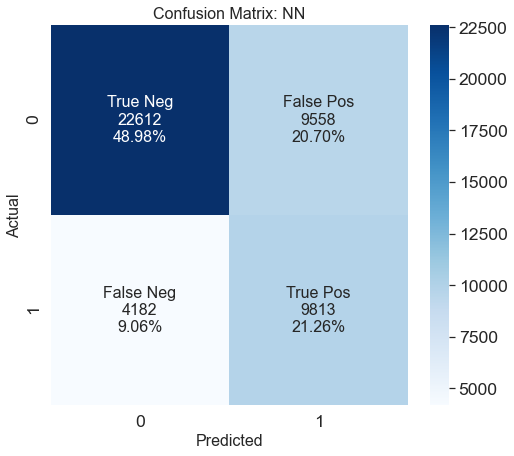

In [36]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_under)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: NN', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
#plt.savefig('plots/confusion_matrix_NN_under.png',dpi=300)

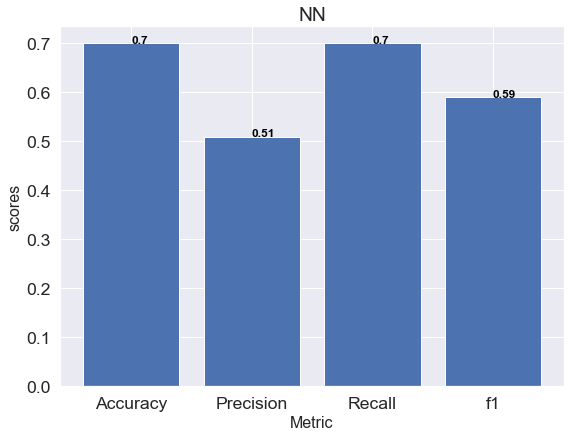

In [37]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
metrics = ['Accuracy', 'Precision', 'Recall', 'f1']
scores = [0.70 ,0.51,0.70,0.59]
ax.bar(metrics,scores)
ax.set_ylabel('scores',fontsize= 16)
ax.set_xlabel('Metric',fontsize= 16)
ax.set_title('NN')
for i, v in enumerate(scores):
    ax.text( i ,v, str(v), color='black', fontweight='bold', fontsize=12)
    #plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

__Conclusion:__ The accuracy and precision of this model are quite lower than for the NN with imbalanced data. Because we want to focus on the Recall and identify as many churning customers as possible we undersampled the data set and as as expected we can see that the prediction for churn improved. The recall also improved by 27% compared to the NN with imbalanced data.

## NN - oversampling
We resample the dataset by oversampling the minority class.

In [46]:
from imblearn.over_sampling import RandomOverSampler
print('Oversampling')
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)

Oversampling


In [47]:
model_over = tf.keras.Sequential([
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(51,)),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(102, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])

In [48]:
model_over.compile(optimizer =get_optimizer(), 
                loss=Loss,
                metrics=[Loss, Recall, Precision,'accuracy'])
   
history_model_over = model_over.fit(X_over, y_over, validation_data=(X_test, y_test), epochs=1000, batch_size=1024,
                                                          callbacks=[cb_epoch_dots],verbose=0) 


Epoch: 0, accuracy:0.6206,  binary_crossentropy:0.6485,  loss:0.6717,  precision:0.6171,  recall:0.6359,  val_accuracy:0.6725,  val_binary_crossentropy:0.6033,  val_loss:0.6231,  val_precision:0.4710,  val_recall:0.6518,  
..........
Epoch: 10, accuracy:0.6978,  binary_crossentropy:0.5820,  loss:0.5904,  precision:0.7047,  recall:0.6809,  val_accuracy:0.7091,  val_binary_crossentropy:0.5715,  val_loss:0.5795,  val_precision:0.5156,  val_recall:0.6661,  
..........
Epoch: 20, accuracy:0.7032,  binary_crossentropy:0.5751,  loss:0.5834,  precision:0.7086,  recall:0.6901,  val_accuracy:0.6989,  val_binary_crossentropy:0.5798,  val_loss:0.5877,  val_precision:0.5025,  val_recall:0.7032,  
..........
Epoch: 30, accuracy:0.7071,  binary_crossentropy:0.5704,  loss:0.5790,  precision:0.7132,  recall:0.6929,  val_accuracy:0.7131,  val_binary_crossentropy:0.5639,  val_loss:0.5721,  val_precision:0.5205,  val_recall:0.6789,  
..........
Epoch: 40, accuracy:0.7096,  binary_crossentropy:0.5667,  lo

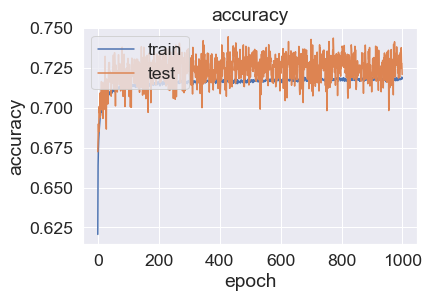

In [49]:
plt.plot(history_model_over.history['accuracy']) 
plt.plot(history_model_over.history['val_accuracy']) 
plt.title('accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

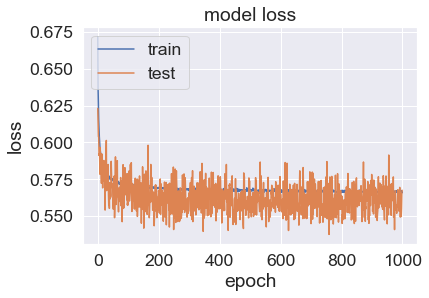

In [50]:
plt.plot(history_model_over.history['loss']) 
plt.plot(history_model_over.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [51]:
# Predicting the Test set results
y_pred_proba_over = model_over.predict(X_test)
#Converting probabilities into a binary result
y_pred_over = (y_pred_proba_over > 0.5)

In [52]:
# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred_over))
print(classification_report(y_test,y_pred_over))

[[23722  8448]
 [ 4438  9557]]
              precision    recall  f1-score   support

           0       0.84      0.74      0.79     32170
           1       0.53      0.68      0.60     13995

    accuracy                           0.72     46165
   macro avg       0.69      0.71      0.69     46165
weighted avg       0.75      0.72      0.73     46165



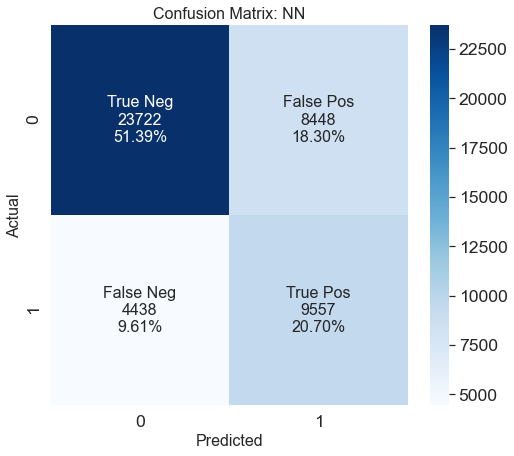

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred_over)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: NN', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
#plt.savefig('plots/confusion_matrix_NN_over.png',dpi=300)

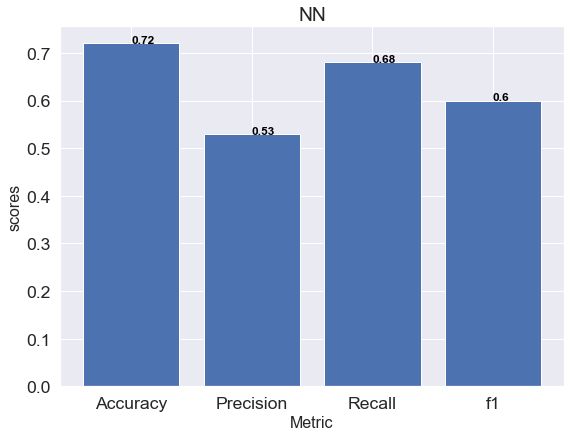

In [54]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
metrics = ['Accuracy', 'Precision', 'Recall', 'f1']
scores = [0.72 ,0.53 ,0.68,0.60]
ax.bar(metrics,scores)
ax.set_ylabel('scores',fontsize= 16)
ax.set_xlabel('Metric',fontsize= 16)
ax.set_title('NN')
for i, v in enumerate(scores):
    ax.text( i ,v, str(v), color='black', fontweight='bold', fontsize=12)
    #plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

__Conclusion:__ We see similar values as with the undersamling NN. However, the recall is slightly lower, the accuracy and the f1 score are slightly higher than the NN before. 

## Follow Up Analysis of the errors

### Create new df

To be able to observe where the Model predicted wrong we are going to have a look at the false positives and False negative values of the test data. <br>
Because the ANN with the undersampled data showed the highest recall the following chapter is going to examine the predicted values and probabilities which are then joined to the test dataframe.

In [57]:
df_post = df_test.copy()

In [59]:
#Create two new dataframes with the predicted churn probability and the predicted churn
df2 = pd.DataFrame(y_pred_under, columns=['churn_pred'])
df3 = pd.DataFrame(y_pred_proba_under, columns=['churn_pred_proba'])

In [60]:
# add columns of new data frames on df_test
df_post['churn_pred'] = df2['churn_pred'].values
df_post['churn_pred_proba'] = df3['churn_pred_proba'].values

In [61]:
df_post

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,...,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel,churn_pred,churn_pred_proba
17293,2015.250000,56,0,0,145,Kleinmachnow,0,0,0,1.0,...,0,1,0,0,1,0,0,0,False,0.358838
140745,2018.833333,14,0,0,694,Weinheim,0,1,0,1.0,...,0,1,0,0,1,0,1,0,True,0.689020
33637,2016.000000,50,0,0,675,Worms,0,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.376776
163048,2018.916667,18,0,0,xx,Luxembourg,0,0,0,1.0,...,0,0,1,0,1,0,1,0,False,0.253123
163616,2018.583333,22,0,0,406,Erkrath,0,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.635113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27608,2014.000000,75,0,0,xx,Wien,1,0,0,1.0,...,0,0,0,1,0,0,1,0,False,0.218062
69011,2017.083333,31,0,0,806,München,1,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.470582
55757,2016.000000,53,0,0,343,Espenau,0,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.749368
12672,2013.833333,76,0,0,104,Berlin,1,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.324495


### False Negatives - on test data 
A __false negative__ is an outcome where the model incorrectly predicts the negative class. In our case the model predicted the customers to not churn, but in reality they did churn. Therefore, the churn prevention activities would miss those wrong predicted customers. 

Actual: 1 <br>
Pred: False

In [62]:
FN = (df_post['churn'] == 1) & (df_post['churn_pred'] == False)
df_FN = df_post[FN]
df_FN

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,...,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel,churn_pred,churn_pred_proba
40292,2015.916667,47,0,0,674,Neustadt,0,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.333027
5069,2014.083333,75,0,0,701,Stuttgart,1,0,1,1.0,...,0,1,0,1,0,0,1,0,False,0.298425
49968,2016.500000,40,0,0,258,Breklum,0,0,0,1.0,...,0,1,0,0,1,0,1,0,False,0.482661
148926,2019.083333,14,0,0,xx,Ehrenhausen/Weinstraße,0,0,0,1.0,...,0,0,0,1,0,0,0,0,False,0.488745
89787,2018.666667,14,0,0,243,Plön,0,4,0,1.0,...,0,1,0,0,1,0,1,0,False,0.324453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154085,2018.416667,13,0,0,xx,Salzburg,0,0,0,1.0,...,0,0,0,1,0,0,1,0,False,0.383503
155609,2019.333333,11,0,1,786,Rottweil,0,0,0,1.0,...,0,1,0,0,1,0,1,0,False,0.367586
7727,2013.500000,73,0,0,818,München,1,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.337601
137661,2019.416667,7,0,0,720,Tübingen,0,0,0,1.0,...,0,1,0,1,0,0,1,0,False,0.101204


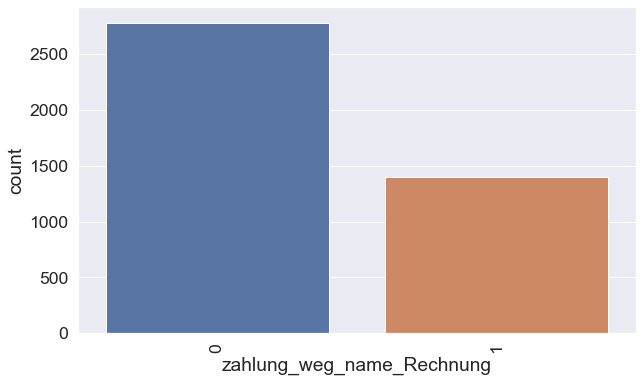

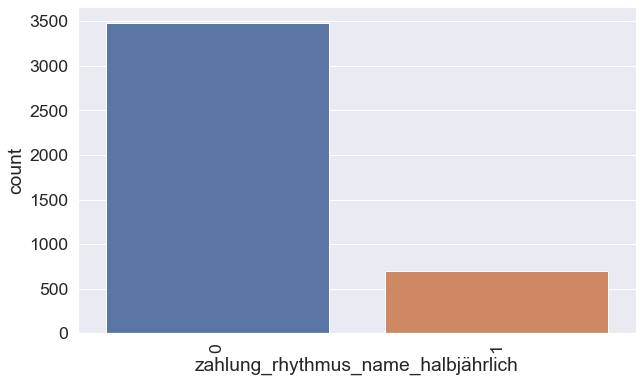

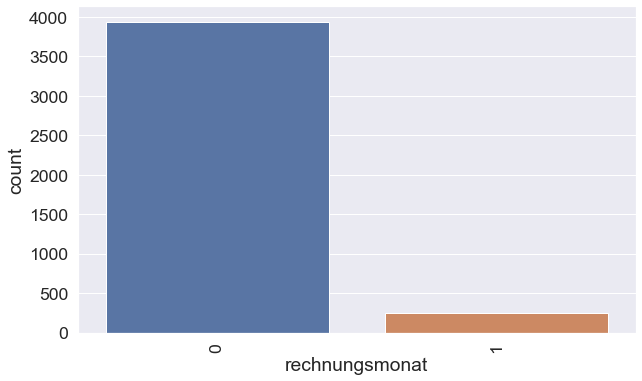

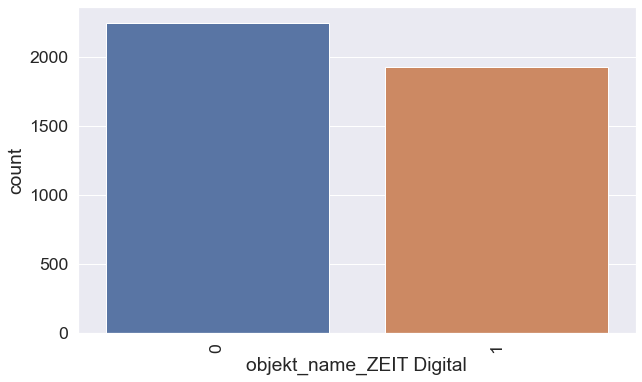

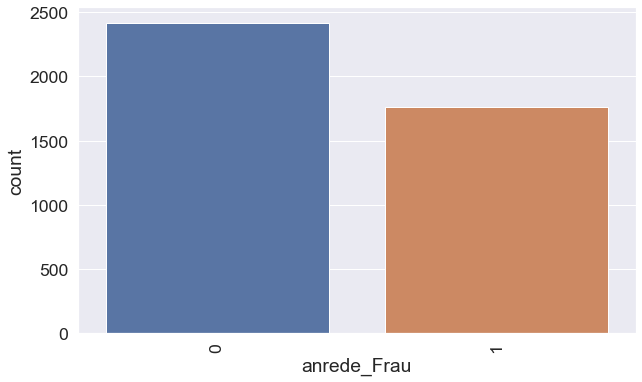

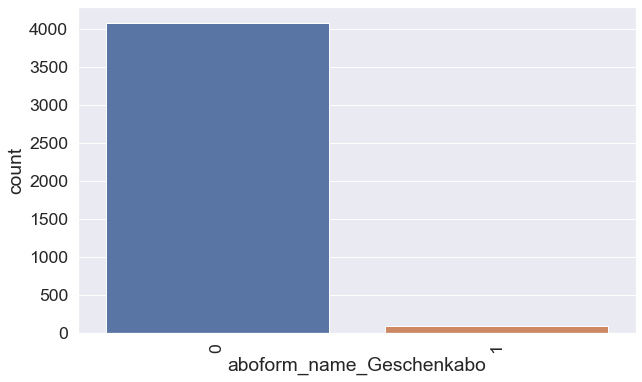

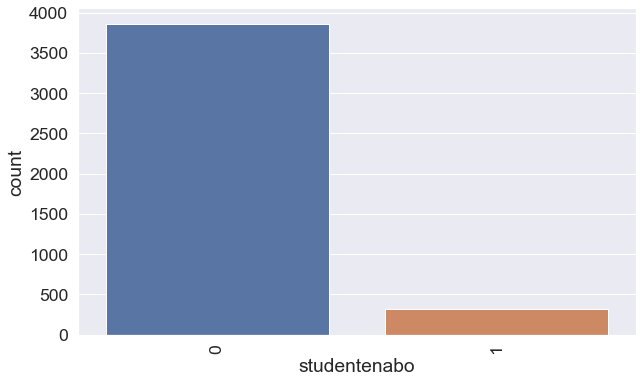

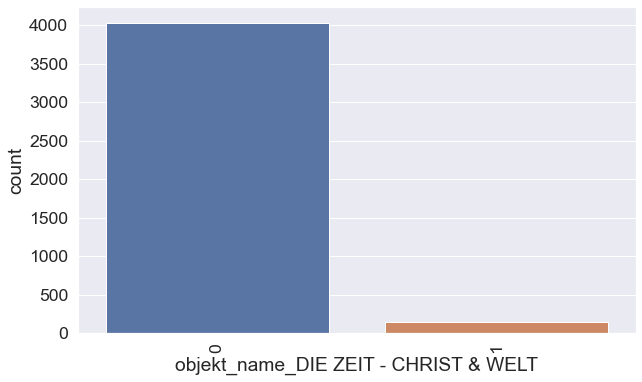

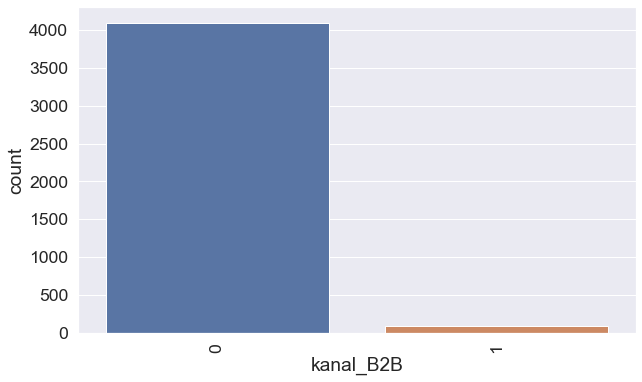

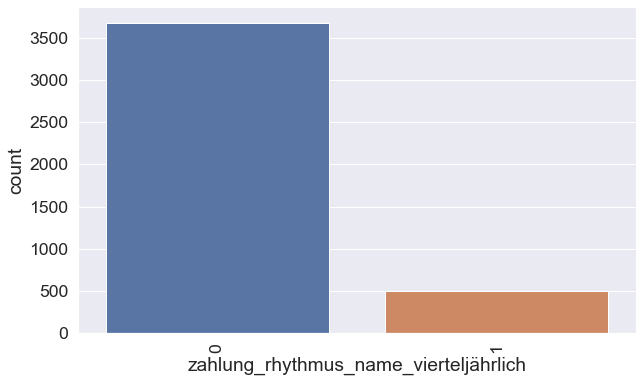

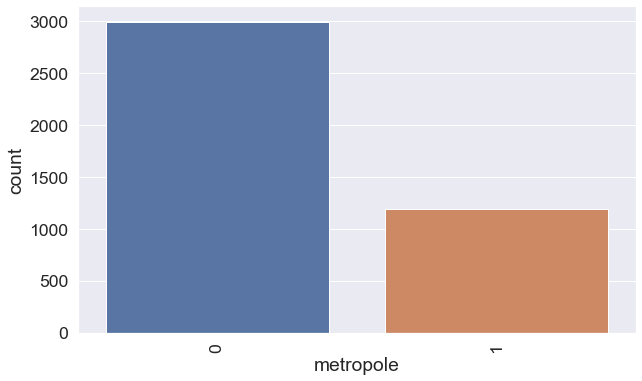

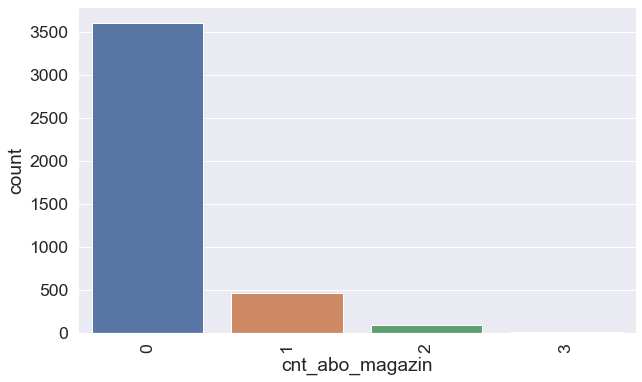

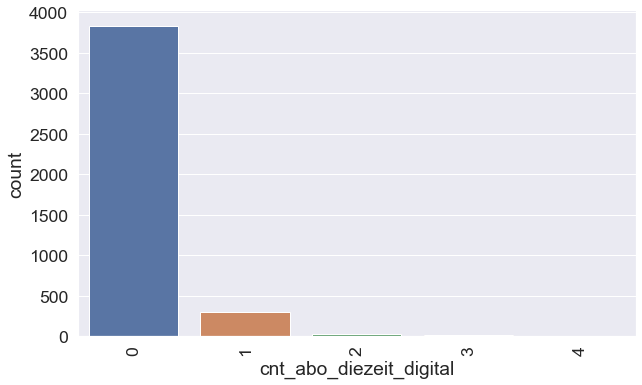

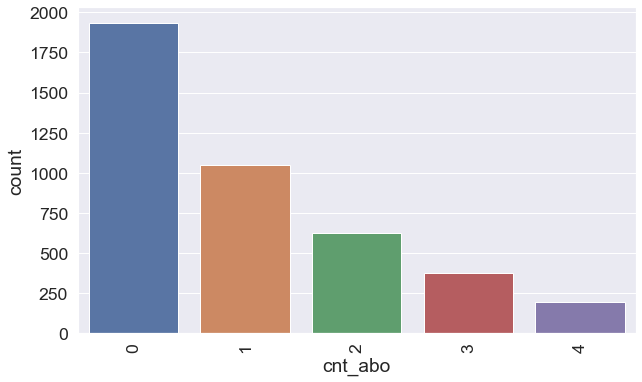

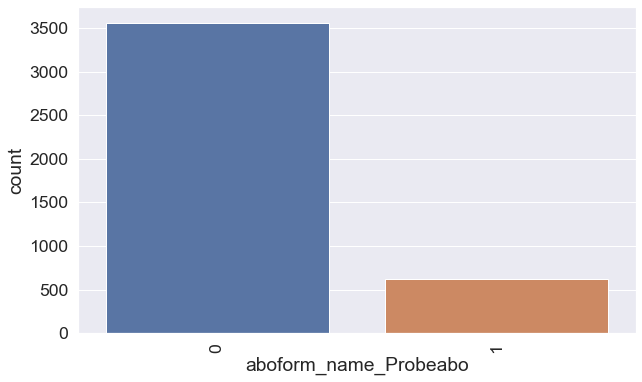

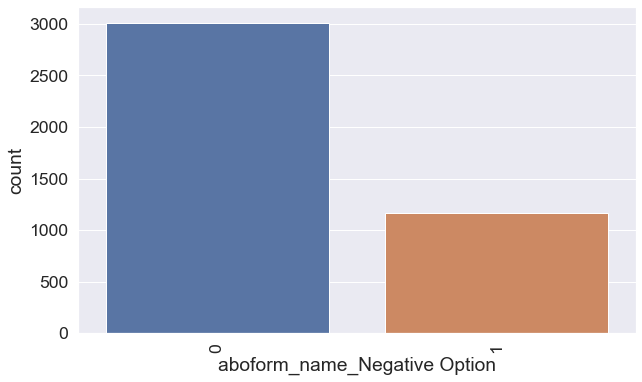

In [64]:
for i, f in enumerate(['zahlung_weg_name_Rechnung','zahlung_rhythmus_name_halbjährlich','rechnungsmonat', 'objekt_name_ZEIT Digital','anrede_Frau',
 'aboform_name_Geschenkabo','studentenabo','objekt_name_DIE ZEIT - CHRIST & WELT','kanal_B2B','zahlung_rhythmus_name_vierteljährlich',
 'metropole','cnt_abo_magazin', 'cnt_abo_diezeit_digital', 'cnt_abo','aboform_name_Probeabo', 'aboform_name_Negative Option']):
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=f, data=df_FN)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

__Conclusion:__ When looking at the missed churn customers (FN), there are some things that stand out, but they should be investigated more thoroughly. At first sight the following is noticeable:
* Most missed churn customers have no Geschenkabo subscription (corresponds with the whole data set)
* Often they also have no student subscription (Studentenabo)
* often no Probeabo subscription 

### False positive - on test data
A __false positive__ is an outcome where the model incorrectly predicts the positive class. In our case the model predicted the customers to churn, but in reality they did not. Therefore, those wrong predicted and loyal customers might be disturbed by churn prevention activities, e.g. mails.

churn: 0 <br>
churn_pred: True

In [63]:
FP = (df_post['churn'] == 0) & (df_post['churn_pred'] == True)
df_FP = df_post[FP]
df_FP

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,plz_3,ort,metropole,shop_kauf,unterbrechung,email_am_kunden,...,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel,churn_pred,churn_pred_proba
140745,2018.833333,14,0,0,694,Weinheim,0,1,0,1.0,...,0,1,0,0,1,0,1,0,True,0.689020
163803,2018.583333,12,1,0,249,Flensburg,0,0,0,1.0,...,0,1,0,0,1,0,1,0,True,0.804000
105208,2017.750000,22,0,0,223,Hamburg,1,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.673442
97538,2017.083333,29,0,0,763,Malsch,0,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.537287
11761,2013.250000,78,0,0,912,Schnaittach,0,0,0,1.0,...,0,1,0,0,1,0,1,0,True,0.537284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177006,2018.833333,8,0,0,013,Dresden,1,0,0,1.0,...,0,1,0,0,1,0,1,0,True,0.772408
177728,2019.333333,3,0,0,664,Bexbach,0,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.666847
175454,2019.333333,8,0,0,687,Schwetzingen,0,0,0,1.0,...,0,1,0,0,1,0,1,0,True,0.753139
55757,2016.000000,53,0,0,343,Espenau,0,0,0,1.0,...,0,1,0,1,0,0,1,0,True,0.749368


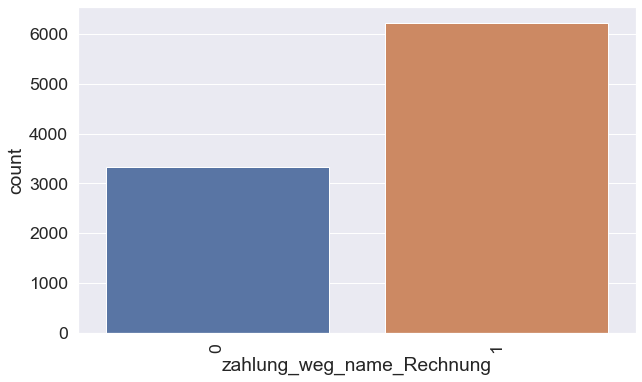

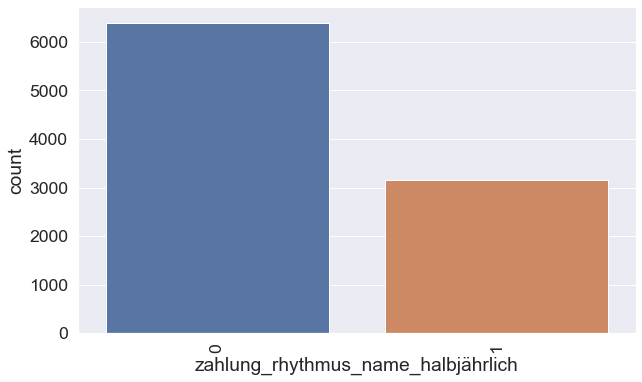

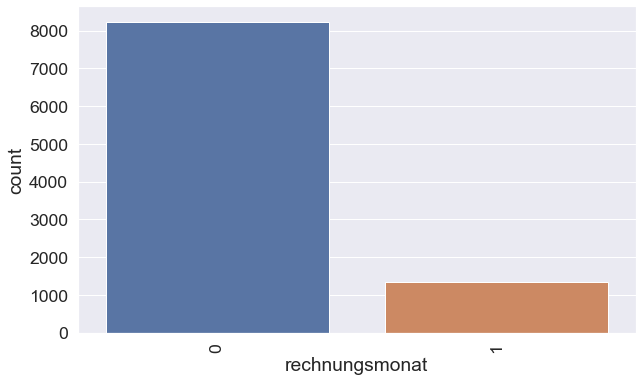

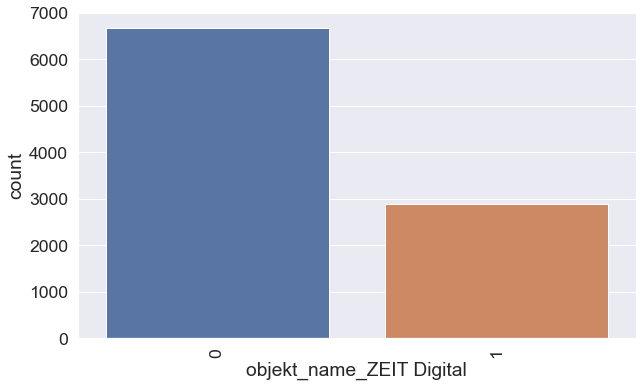

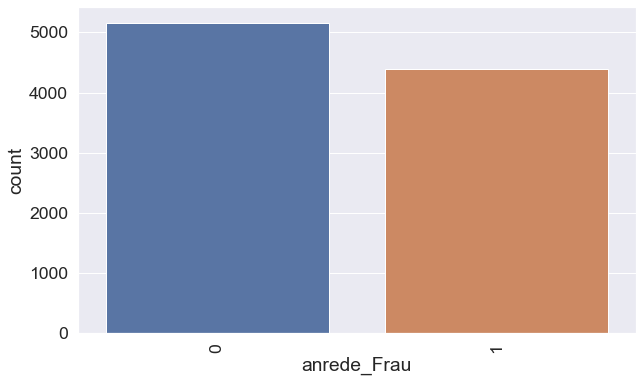

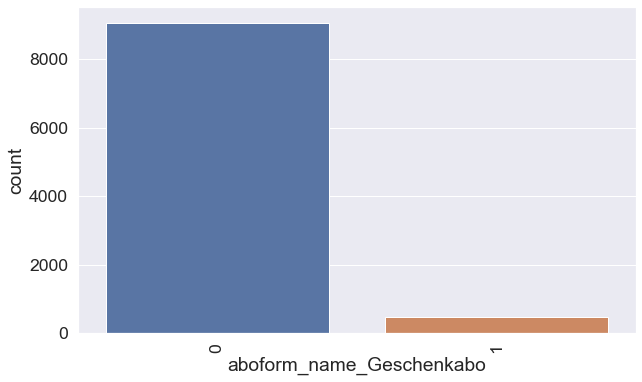

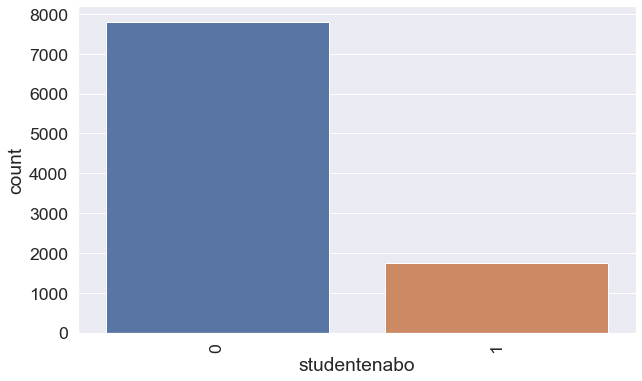

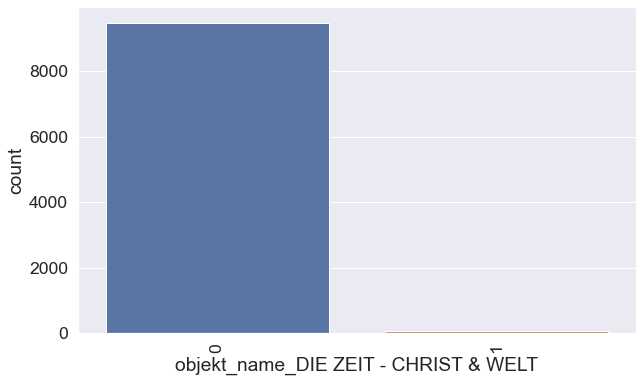

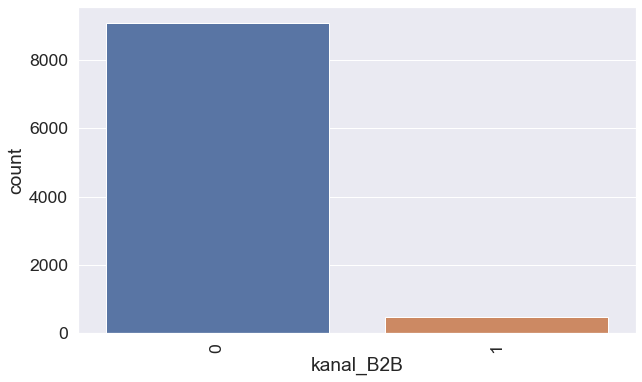

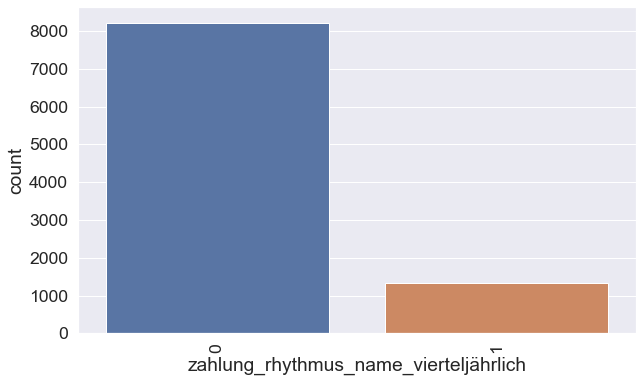

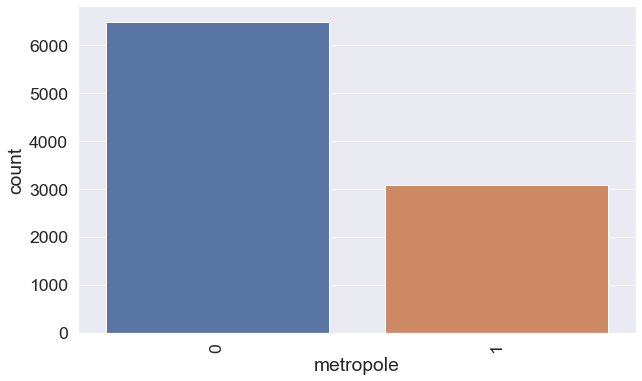

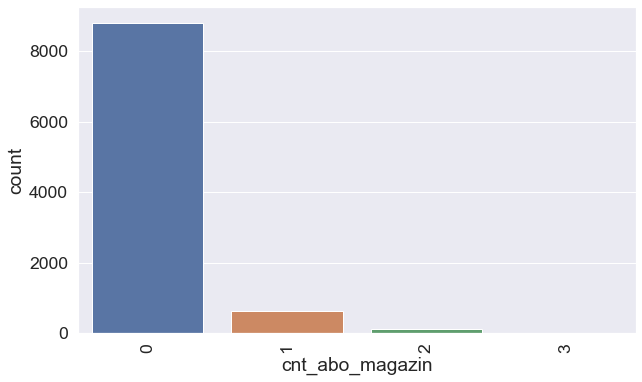

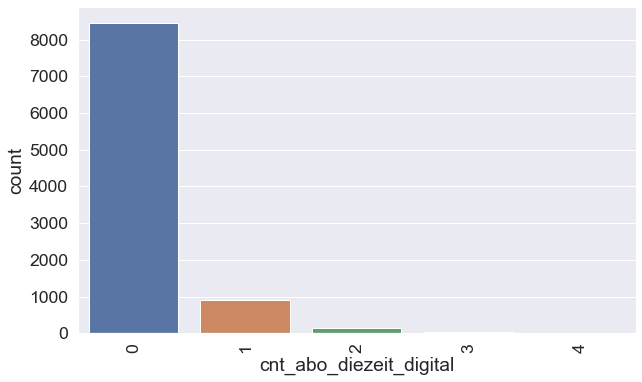

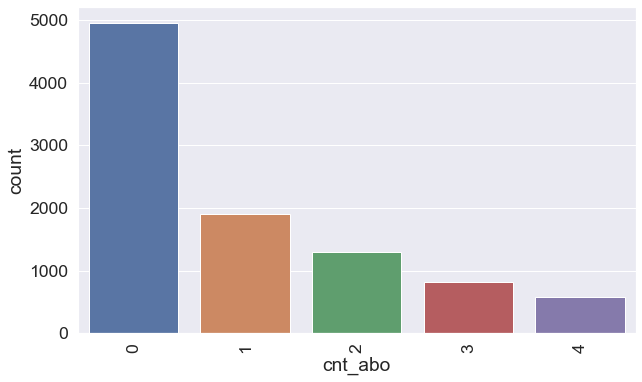

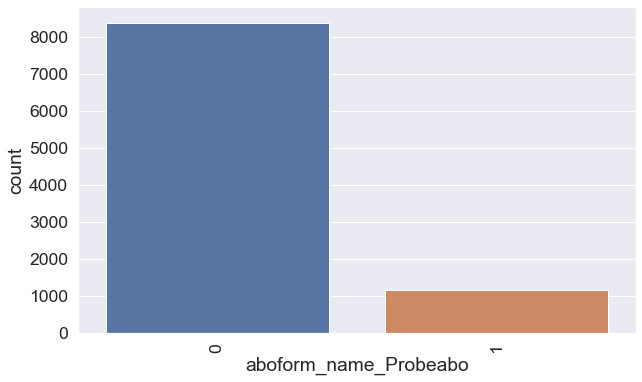

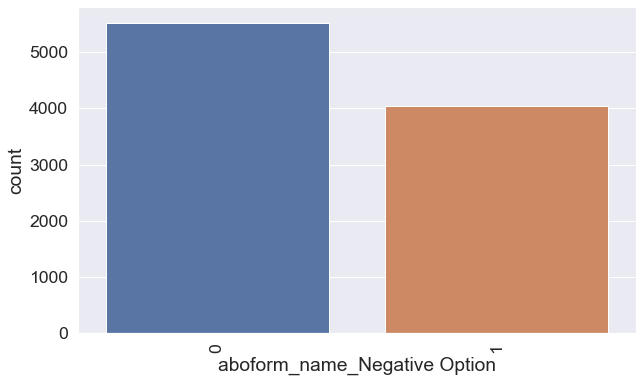

In [65]:
for i, f in enumerate(['zahlung_weg_name_Rechnung','zahlung_rhythmus_name_halbjährlich','rechnungsmonat', 'objekt_name_ZEIT Digital','anrede_Frau',
 'aboform_name_Geschenkabo','studentenabo','objekt_name_DIE ZEIT - CHRIST & WELT','kanal_B2B','zahlung_rhythmus_name_vierteljährlich',
 'metropole','cnt_abo_magazin', 'cnt_abo_diezeit_digital', 'cnt_abo','aboform_name_Probeabo', 'aboform_name_Negative Option']):
    
    
    plt.subplots(figsize=(10,6))
    ax = sns.countplot(x=f, data=df_FP)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

__Conclusion:__ When looking at the false identified churn customers (FP), there are some things that stand out, but they should be investigated more thoroughly. At first sight the following is noticeable:
* Payment on account (Rechung) exactly the other way round as with the FN. Many who pay on account were wrongly classified.
* Many wrongly classified which have the trial subscription (Probeabo)
* Also many false predicted who have a negative option subscription

__These findings would have to be examined more closely and then, based on the new findings, the features could be adapted or engineered accordingly.__

# ANN with embedding of categorical variables (deep and wide)

Based on the basic ANN an embedding of the categorical variables is developed here to try to further improve the results of the ANN. 

## Imports, Load Data, Preprocessing

In [1459]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Encoding the Independent Variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score, precision_score
from sklearn.pipeline import Pipeline

#Importing Keras & classes
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate
from keras.callbacks import TensorBoard
from keras.metrics import Recall, Precision
from keras.layers.merge import concatenate
from keras import backend as K
import pydot
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
from keras.utils.vis_utils import plot_model

# Import tensorflow 
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# random state
random_state = 100

In [1391]:
df = pd.read_csv('data/df_clean_engineered_all.csv')

In [1392]:
y = df['churn'] 

In [1395]:
# list of all categorical variables
cat_list = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
            'zahlung_weg_name', 'plz_1', 'plz_2', 'plz_3','land_iso_code', 
            'anrede', 'titel']

In [1396]:
all_numeric_features = list(df.columns[df.dtypes != object])

In [1397]:
# list of all numeric features (without churn)
all_numeric_features.remove('churn')

In [1399]:
# the top 51 features without the categorical features = 37 features)
num_features = ['rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'unsubscribed_anzahl_1m',
 'studentenabo',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'opened_anzahl_bestandskunden_6m',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_opened_1m',
 'clicked_anzahl_6m',
 'che_reg',
 'MONTH_DELTA_nl_min',
 'zon_zp_red',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'shop_kauf',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'openrate_3m',
 'openrate_1m',
 'nl_unsubscribed_6m',
 'nl_fdz_organisch',
 'metropole',
 'cnt_abo_magazin',
 'cnt_abo_diezeit_digital',
 'cnt_abo',
 'clicked_anzahl_bestandskunden_3m',
 'MONTH_DELTA_abo_min']

### Label encoding for 'plz_3'

In [1400]:
# label encoding for plz before train test split to have all unique values included in the encoding
LE_plz = LabelEncoder()
df['plz_3'] = LE_plz.fit_transform(df['plz_3'])
n_plz_3 = len(df['plz_3'].unique())

In [1402]:
# split train and test set
df, df_test = train_test_split(df, random_state=random_state, stratify=y)

In [1]:
Undersampling = True
Oversampling = False

In [ ]:
if Undersampling:
    print('Undersampling')
    # define undersample strategy
    undersample = RandomUnderSampler(sampling_strategy='majority')
    X_undersample, y_undersample = undersample.fit_resample(df, df['churn'])
    # write back to dataframe
    df = X_undersample

In [ ]:
if Oversampling:
    print('Oversampling')
    # define oversample strategy
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_oversample, y_oversample = oversample.fit_resample(df, df['churn'])
    # write back to dataframe
    df = X_oversample

### Setup for ANN

In [1405]:
# check shape if under- or oversampling active
df.shape

(83970, 185)

In [1406]:
BATCH_SIZE = 1024
STEPS_PER_EPOCH = df.shape[0]//BATCH_SIZE
STEPS_PER_EPOCH

82

In [1407]:
init_learning_rate = 0.01
epochs_per_decay = 200 
decay_rate = 1

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  init_learning_rate,
  decay_steps=STEPS_PER_EPOCH*epochs_per_decay,
  decay_rate=decay_rate,
  staircase=False)

def get_optimizer(LR_decay):
    if LR_decay:
        return tf.keras.optimizers.Adam(lr_schedule)
    else: 
        return tf.keras.optimizers.Adam()

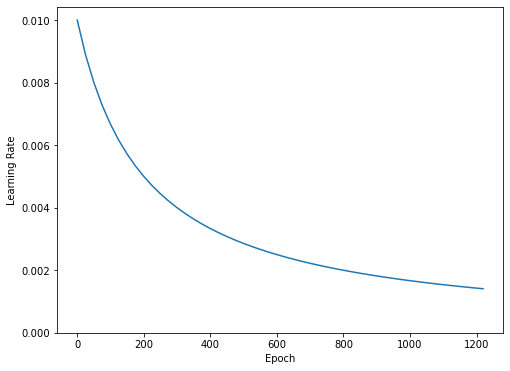

In [1408]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [1445]:
loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy')

In [1446]:
Recall = keras.metrics.Recall(name='recall')
Precision = keras.metrics.Precision(name='precision')

In [1447]:
cb_recall = tf.keras.callbacks.EarlyStopping(monitor='recall', patience=100)
cb_epoch_dots = tfdocs.modeling.EpochDots(report_every=10)

### Encoding of all categorical variables

In [1409]:
le = LabelEncoder()

In [ ]:
# categorical feature - Kanal
cat_kanal = df['kanal']
cat_kanal_test = df_test['kanal']
n_kanal = len(cat_kanal.unique())
embedding_size_kanal = min(50,  (n_kanal+1)// 2)
# encode the cat feature
cat_kanal = le.fit_transform(cat_kanal)
cat_kanal_test = le.transform(cat_kanal_test)

In [ ]:
# categorical feature - Kanal
cat_objektname = df['objekt_name']
cat_objektname_test = df_test['objekt_name']
n_objektname = len(cat_objektname.unique())
embedding_size_objektname = min(50,  (n_objektname+1)// 2)
# encode the cat feature
cat_objektname = le.fit_transform(cat_objektname)
cat_objektname_test = le.transform(cat_objektname_test)

In [1413]:
# categorical feature - aboform_name
cat_aboform_name = df['aboform_name']
cat_aboform_name_test = df_test['aboform_name']
n_aboform_name = len(cat_aboform_name.unique())
embedding_size_aboform_name = min(50,  (n_aboform_name+1)// 2)
# encode the cat feature
cat_aboform_name = le.fit_transform(cat_aboform_name)
cat_aboform_name_test = le.transform(cat_aboform_name_test)

In [1414]:
# categorical feature - zahlung_rhythmus_name
cat_zahlung_rhythmus_name = df['zahlung_rhythmus_name']
cat_zahlung_rhythmus_name_test = df_test['zahlung_rhythmus_name']
n_zahlung_rhythmus_name = len(cat_zahlung_rhythmus_name.unique())
embedding_size_zahlung_rhythmus_name = min(50,  (n_zahlung_rhythmus_name+1)// 2)
# encode the cat feature
cat_zahlung_rhythmus_name = le.fit_transform(cat_zahlung_rhythmus_name)
cat_zahlung_rhythmus_name_test = le.transform(cat_zahlung_rhythmus_name_test)

In [1415]:
# categorical feature - zahlung_weg_name
cat_zahlung_weg_name = df['zahlung_weg_name']
cat_zahlung_weg_name_test = df_test['zahlung_weg_name']
n_zahlung_weg_name = len(cat_zahlung_weg_name.unique())
embedding_size_zahlung_weg_name = min(50,  (n_zahlung_weg_name+1)// 2)
# encode the cat feature
cat_zahlung_weg_name = le.fit_transform(cat_zahlung_weg_name)
cat_zahlung_weg_name_test = le.transform(cat_zahlung_weg_name_test)

In [1416]:
# categorical feature - plz_1
cat_plz_1 = df['plz_1']
cat_plz_1_test = df_test['plz_1']
n_plz_1 = len(cat_plz_1.unique())
embedding_size_plz_1 = min(50,  (n_plz_1+1)// 2)
# encode the cat feature
cat_plz_1 = le.fit_transform(cat_plz_1)
cat_plz_1_test = le.transform(cat_plz_1_test)

In [1417]:
# categorical feature - plz_2
cat_plz_2 = df['plz_2']
cat_plz_2_test = df_test['plz_2']
n_plz_2 = len(cat_plz_2.unique())
embedding_size_plz_2 = min(50,  (n_plz_2+1)// 2)
# encode the cat feature
cat_plz_2 = le.fit_transform(cat_plz_2)
cat_plz_2_test = le.transform(cat_plz_2_test)

In [1418]:
# categorical feature - land_iso_code
cat_land_iso_code = df['land_iso_code']
cat_land_iso_code_test = df_test['land_iso_code']

n_land_iso_code = len(cat_land_iso_code.unique())
embedding_size_land_iso_code = min(50,  (n_land_iso_code+1)// 2)
# encode the cat feature
cat_land_iso_code = le.fit_transform(cat_land_iso_code)
cat_land_iso_code_test = le.transform(cat_land_iso_code_test)

In [1419]:
# categorical feature - anrede
cat_anrede = df['anrede']
cat_anrede_test = df_test['anrede']
n_anrede = len(cat_anrede.unique())
embedding_size_anrede = min(50,  (n_anrede+1)// 2)
# encode the cat feature
cat_anrede = le.fit_transform(cat_anrede)
cat_anrede_test = le.transform(cat_anrede_test)

In [1420]:
# categorical feature - titel
cat_titel = df['titel']
cat_titel_test = df_test['titel']

n_titel = len(cat_titel.unique())
embedding_size_titel = min(50,  (n_titel+1)// 2)
# encode the cat feature
cat_titel = le.fit_transform(cat_titel)
cat_titel_test = le.transform(cat_titel_test)

In [1421]:
# categorical feature - plz3
cat_plz_3 = df['plz_3']
cat_plz_3_test = df_test['plz_3']

#n_plz_3 = len(cat_plz_3.unique())
embedding_size_plz_3 = min(50,  (n_plz_3+1)// 2)
# encode the cat feature
#cat_plz_3 = le.fit_transform(cat_plz_3)
#cat_plz_3_test = le.transform(cat_plz_3_test)

### set target churn

In [1422]:
# target
target = df['churn']
target_test = df_test['churn']
target = target.to_numpy()
target_test = target_test.to_numpy()

## data imbalance handling possobilities: class weights and focal loss function

In [1423]:
neg, pos = np.bincount(target)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 83970
    Positive: 41985 (50.00% of total)



In [1424]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [2]:
# Define custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0 
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

### Numerical Features & Scaling

In [1426]:
# numerical feature
num = df[num_features]
#num = df[all_numeric_features]
num_test = df_test[num_features]
#num_test = df_test[all_numeric_features]
print(num.shape[1])
print(num.shape[0])

37
83970
<class 'pandas.core.frame.DataFrame'>


In [1427]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
num = scaler.fit_transform(num)
num_test = scaler.transform(num_test)

### Setup of input layer and embedding layer

In [1428]:
# Use Input layers, specify input shape (dimensions except first)

# cat Inputs
inp_cat_kanal = keras.layers.Input(shape=(1,)) 
inp_cat_objekt_name = keras.layers.Input(shape=(1,))
inp_cat_aboform_name = keras.layers.Input(shape=(1,)) 
inp_cat_zahlung_rhythmus_name = keras.layers.Input(shape=(1,)) 
inp_cat_zahlung_weg_name = keras.layers.Input(shape=(1,)) 
inp_cat_plz_1 = keras.layers.Input(shape=(1,))
inp_cat_plz_2 = keras.layers.Input(shape=(1,))
inp_cat_land_iso_code = keras.layers.Input(shape=(1,))
inp_cat_anrede = keras.layers.Input(shape=(1,))
inp_cat_titel = keras.layers.Input(shape=(1,))
inp_cat_plz3 = keras.layers.Input(shape=(1,))

# numerical input
inp_num_data = keras.layers.Input(shape=(num.shape[1],))

In [1429]:
# Embedding layer - kanal
emb_kanal = keras.layers.Embedding(input_dim=n_kanal, output_dim=embedding_size_kanal)(inp_cat_kanal)  
flatten_kanal = keras.layers.Flatten()(emb_kanal)

In [1430]:
# Embedding layer - objekt_name
emb_objekt_name = keras.layers.Embedding(input_dim=n_objektname, output_dim=embedding_size_objektname)(inp_cat_objekt_name)  
flatten_objekt_name = keras.layers.Flatten()(emb_objekt_name)

In [1431]:
# Embedding layer - aboform_name
emb_aboform_name = keras.layers.Embedding(input_dim=n_aboform_name, output_dim=embedding_size_aboform_name)(inp_cat_aboform_name)  
flatten_aboform_name = keras.layers.Flatten()(emb_aboform_name)

In [1432]:
# Embedding layer - zahlung_rhythmus_name
emb_zahlung_rhythmus_name = keras.layers.Embedding(input_dim=n_zahlung_rhythmus_name, output_dim=embedding_size_zahlung_rhythmus_name)(inp_cat_zahlung_rhythmus_name)  
flatten_zahlung_rhythmus_name = keras.layers.Flatten()(emb_zahlung_rhythmus_name)

In [1433]:
# Embedding layer - zahlung_weg_name
emb_zahlung_weg_name = keras.layers.Embedding(input_dim=n_zahlung_weg_name, output_dim=embedding_size_zahlung_weg_name)(inp_cat_zahlung_weg_name)  
flatten_zahlung_weg_name = keras.layers.Flatten()(emb_zahlung_weg_name)

In [1434]:
# Embedding layer - plz_1
emb_plz_1 = keras.layers.Embedding(input_dim=n_plz_1, output_dim=embedding_size_plz_1)(inp_cat_plz_1)  
flatten_plz_1 = keras.layers.Flatten()(emb_plz_1)

In [1435]:
# Embedding layer - plz_2
emb_plz_2 = keras.layers.Embedding(input_dim=n_plz_2, output_dim=embedding_size_plz_2)(inp_cat_plz_2)  
flatten_plz_2 = keras.layers.Flatten()(emb_plz_2)

In [1436]:
# Embedding layer - land_iso_code
emb_land_iso_code = keras.layers.Embedding(input_dim=n_land_iso_code, output_dim=embedding_size_land_iso_code)(inp_cat_land_iso_code)  
flatten_land_iso_code = keras.layers.Flatten()(emb_land_iso_code)

In [1437]:
# Embedding layer - anrede
emb_anrede = keras.layers.Embedding(input_dim=n_anrede, output_dim=embedding_size_anrede)(inp_cat_anrede)  
flatten_anrede = keras.layers.Flatten()(emb_anrede)

In [1438]:
# Embedding layer - titel
emb_titel = keras.layers.Embedding(input_dim=n_titel, output_dim=embedding_size_titel)(inp_cat_titel)  
flatten_titel = keras.layers.Flatten()(emb_titel)

In [1439]:
# Embedding layer - plz_3
emb_plz_3 = keras.layers.Embedding(input_dim=n_plz_3, output_dim=embedding_size_plz_3)(inp_cat_plz3)  
flatten_plz_3 = keras.layers.Flatten()(emb_plz_3)

In [1440]:
# Concatenate the categorical layers
conc_cat = keras.layers.Concatenate()([flatten_kanal,
                                   flatten_objekt_name,
                                   flatten_aboform_name,
                                   flatten_zahlung_rhythmus_name, 
                                   flatten_zahlung_weg_name,
                                   flatten_plz_1,
                                   flatten_plz_2,
                                   flatten_land_iso_code,
                                   flatten_anrede,
                                   flatten_titel,
                                   flatten_plz_3])

In [1442]:
# first num layer (dense)
dense_num = keras.layers.Dense(num.shape[1], activation="relu")(inp_num_data) 

In [1443]:
# combine the output of the embedding layer with the numerical layer
conc_cat_and_num = keras.layers.Concatenate()([conc_cat, dense_num])

## NN - undersampling with selected numeric features and embedding of categorical features

In [1448]:
#first dense layer = number of inputs dimension = 163
dense1 = keras.layers.Dense(163, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001))(conc_cat_and_num)

# dropout layer 1
do1 = keras.layers.Dropout(0.5)(dense1)

# second dense layer
dense2 = keras.layers.Dense(163, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.0001))(do1)

# dropout layer 2
do2 = keras.layers.Dropout(0.5)(dense2)

# third dense layer
dense3 = keras.layers.Dense(163, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001))(do2)

# dropout layer 3
do3 = keras.layers.Dropout(0.5)(dense3)

# output layer - sigmoid for binary classification
out = keras.layers.Dense(1, activation="sigmoid")(do3)

# Creating output layer
model_163 = keras.Model(inputs=[inp_cat_kanal, 
                            inp_cat_objekt_name, 
                            inp_cat_aboform_name,
                            inp_cat_zahlung_rhythmus_name,
                            inp_cat_zahlung_weg_name,
                            inp_cat_plz_1,
                            inp_cat_plz_2,
                            inp_cat_land_iso_code,
                            inp_cat_anrede,
                            inp_cat_titel,
                            inp_cat_plz3,
                            inp_num_data], outputs=out)

model_163.compile(optimizer=get_optimizer(False),
              loss=loss,
              metrics=[Recall, Precision,'accuracy'])

print(model_163.summary())

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_301 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_302 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_303 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_304 (InputLayer)          (None, 1)            0                                            
___________________________________________________________________________________________

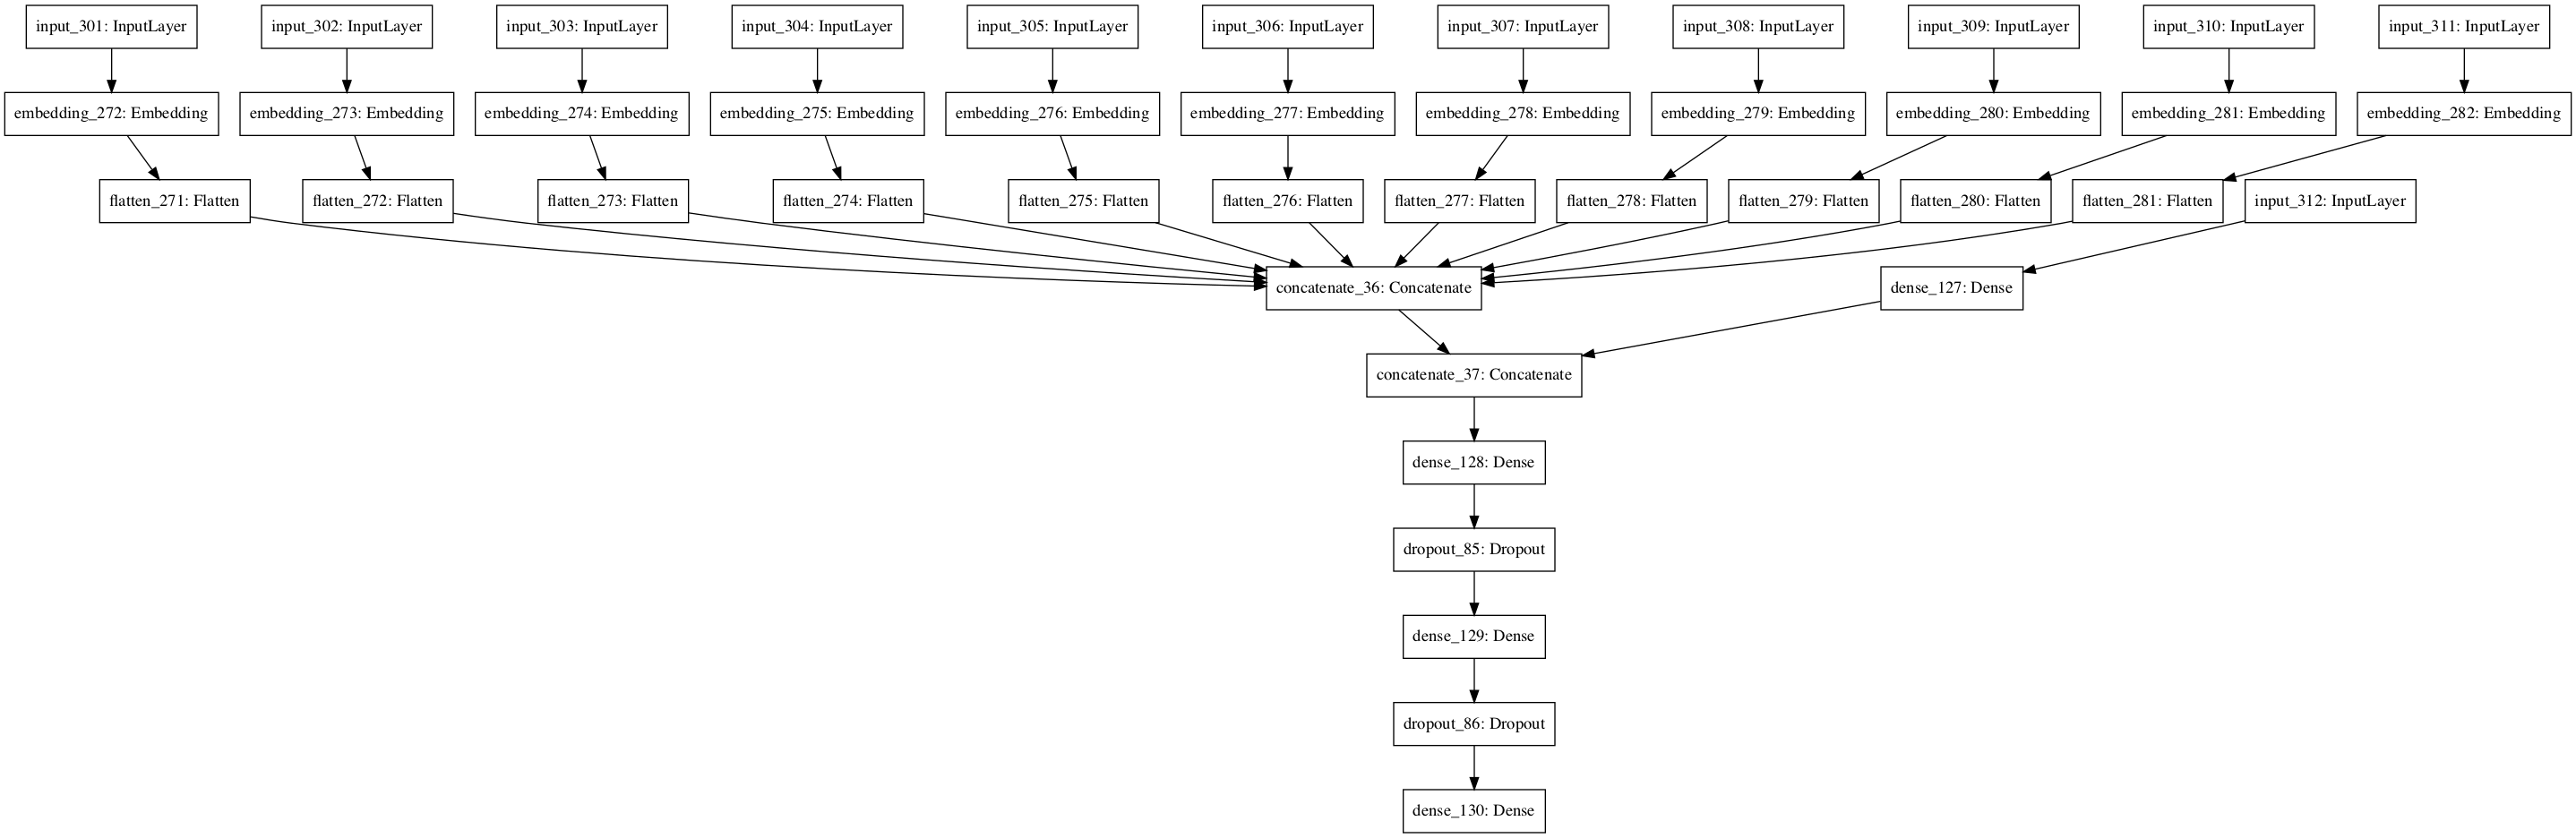

In [1449]:
plot_model(model_163, to_file='model.png')

In [1450]:
history_model_163 = model_163.fit([cat_kanal,
                                           cat_objektname, 
                                           cat_aboform_name,
                                           cat_zahlung_rhythmus_name,
                                           cat_zahlung_weg_name,
                                           cat_plz_1,
                                           cat_plz_2,
                                           cat_land_iso_code,
                                           cat_anrede,
                                           cat_titel,
                                           cat_plz_3,
                                           num], target,
                                           validation_data=(
                                          [cat_kanal_test, 
                                           cat_objektname_test, 
                                           cat_aboform_name_test,
                                           cat_zahlung_rhythmus_name_test,
                                           cat_zahlung_weg_name_test,
                                           cat_plz_1_test,
                                           cat_plz_2_test,
                                           cat_land_iso_code_test,
                                           cat_anrede_test,
                                           cat_titel_test,
                                           cat_plz_3_test,
                                           num_test], target_test),
                                           epochs=1000, 
                                           batch_size=1024,
                                           callbacks=[cb_epoch_dots],
                                           verbose=0)


Epoch: 0, accuracy:0.6160,  loss:0.7354,  precision:0.6053,  recall:0.6668,  val_accuracy:0.6280,  val_loss:0.6607,  val_precision:0.4295,  val_recall:0.6912,  
..........
Epoch: 10, accuracy:0.7008,  loss:0.5921,  precision:0.6973,  recall:0.7097,  val_accuracy:0.6669,  val_loss:0.6116,  val_precision:0.4690,  val_recall:0.7481,  
..........
Epoch: 20, accuracy:0.7073,  loss:0.5789,  precision:0.7035,  recall:0.7167,  val_accuracy:0.6919,  val_loss:0.5866,  val_precision:0.4944,  val_recall:0.7183,  
..........
Epoch: 30, accuracy:0.7105,  loss:0.5750,  precision:0.7056,  recall:0.7223,  val_accuracy:0.6903,  val_loss:0.5936,  val_precision:0.4927,  val_recall:0.7280,  
..........
Epoch: 40, accuracy:0.7173,  loss:0.5625,  precision:0.7137,  recall:0.7256,  val_accuracy:0.6993,  val_loss:0.5896,  val_precision:0.5029,  val_recall:0.7125,  
..........
Epoch: 50, accuracy:0.7192,  loss:0.5657,  precision:0.7196,  recall:0.7181,  val_accuracy:0.6880,  val_loss:0.5996,  val_precision:0.4

## Visualization

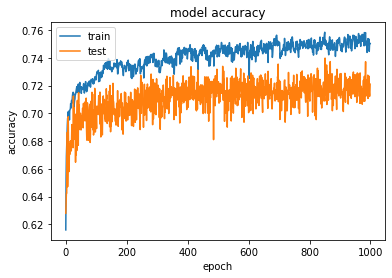

In [1455]:
plt.plot(history_model_163.history['accuracy']) 
plt.plot(history_model_163.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

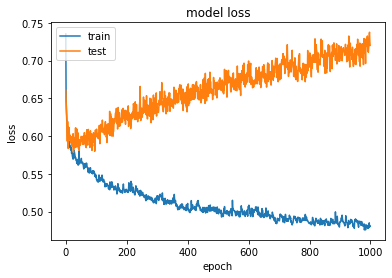

In [1456]:
plt.plot(history_model_163.history['loss'])
plt.plot(history_model_163.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [1457]:
# Predicting the test set results
y_pred_proba_163 = model_163.predict([cat_kanal_test, 
                                       cat_objektname_test, 
                                       cat_aboform_name_test,
                                       cat_zahlung_rhythmus_name_test,
                                       cat_zahlung_weg_name_test,
                                       cat_plz_1_test,
                                       cat_plz_2_test,
                                       cat_land_iso_code_test,
                                       cat_anrede_test,
                                       cat_titel_test,
                                       cat_plz_3_test,
                                       num_test])
#Converting probabilities into a binary result
y_pred_163 = (y_pred_proba_163 >= 0.5)

In [1458]:
# Making the Confusion Matrix
cm = confusion_matrix(target_test, y_pred_163)
print(cm)
print('Recall: ',recall_score(target_test,y_pred_163))
print('Precision: ',precision_score(target_test,y_pred_163))
print('Accuracy: ',accuracy_score(target_test,y_pred_163))

[[23462  8708]
 [ 4168  9827]]
Recall:  0.7021793497677742
Precision:  0.530186134340437
Accuracy:  0.7210874038773963


**Conclusion**:

Despite the larger effort to create all the layers for the embedding of the categorical features, the recall is lower than for our best machine learning methods. In the example here undersampling was used, without the recall is even worse.  The accuracy of the model seems to be okay. 

A lot of different parameter have been tested with the embedding ANN but the results did not improve significantly. Either the ANN structure or the setup is preventing this method to achieve better results than the machine learning methods we used. 